In [1]:
!pip install pyexasol
!pip install websocket-client ujson
!pip install pyodbc

In [1]:
import pyexasol
import pandas as pd

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

# Connection parameters - change the fingerprint each time you start the database

host = '192.168.56.101/E176DDD5013BFA9B9FAF6E470EF099181698FC0ED1817158CE84911F02345B5E:8563'  # Replace with your Exasol host (e.g., '192.168.0.100:8563')
user = 'sys'     # Replace with your Exasol username
password = 'exasol' # Replace with your Exasol password

# Connect to Exasol
conn = pyexasol.connect(dsn=host, user=user, password=password, debug=False, protocol_version=pyexasol.PROTOCOL_V1)






# At what times of the day/week are people using youtube?

#### Obtain Table

In [2]:
q = '''
SELECT QUERYDIM.QUERY, TIMEDIM.[month], TIMEDIM.[day of the month], (TIMEDIM.[day of the year] - 60) as DaysAfterDBStart, TIMEDIM.[hour], TIMEDIM.[minute], FACTS.QUERYID, FACTS.TIMEID, FACTS.ANONID, (TIMEDIM.[hour]*60 + TIMEDIM.[minute]) as MinutesAfterMidnight
FROM AOL_SCHEMA.QUERYDIM 
    LEFT JOIN AOL_SCHEMA.FACTS ON QUERYDIM.ID = FACTS.QUERYID
    LEFT JOIN AOL_SCHEMA.TIMEDIM ON QUERYDIM.ID = TIMEDIM.ID
    LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
WHERE FACTS.CLICK = 1 AND URLDIM.URL = 'http://www.youtube.com'
    AND (QUERYDIM.QUERY IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
        AND QUERYDIM.QUERY NOT LIKE '%youtube%'
        AND QUERYDIM.QUERY NOT LIKE '%you tube%'
        AND QUERYDIM.QUERY NOT LIKE '%your tube%')
'''
# Select (see select clause) when the youtube link was clicked

df = printQuery(q, conn)
print(df.shape, df.columns, sep="\n")




                            QUERY      month  day of the month  \
0                     jake peyton  march                     1   
1             bush drinking video  april                    26   
2  cant stop scratching my vagina  april                    26   
3                      vid idiots  april                    19   
4                 naruto websites  may                       9   

   DAYSAFTERDBSTART  hour  minute  QUERYID   TIMEID  ANONID  \
0                 0     0      13  2775687  5962961  154767   
1                56     9      31  2778308  5986392   53322   
2                56     2      19  2774391  4104872  317691   
3                49    16       6  2785441  2778338  126651   
4                69    15      44  2787473  5086065    7725   

   MINUTESAFTERMIDNIGHT  
0                    13  
1                   571  
2                   139  
3                   966  
4                   944  
(2028, 10)
Index(['QUERY', 'month', 'day of the month', 'DAYSAFTERDB

#### Combined hourly frequency of clicks

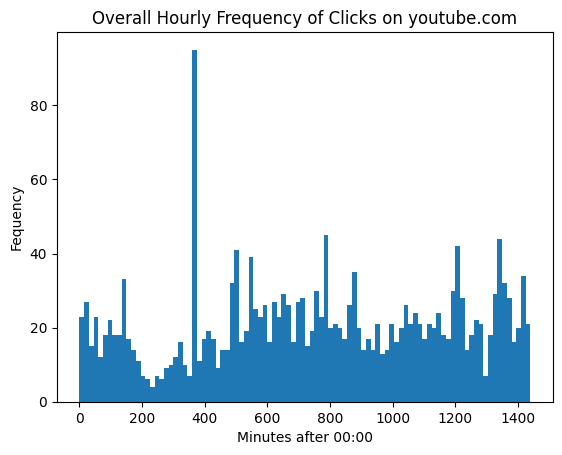

In [3]:
import matplotlib.pyplot as plt

# Overall Hourly Frequency
plt.hist(df['MINUTESAFTERMIDNIGHT'], bins=96)  # Each bin represents a 15 minute period
plt.xlabel("Minutes after 00:00")
plt.ylabel("Fequency")
plt.title("Overall Hourly Frequency of Clicks on youtube.com")
plt.show()


#### Frequency of clicks by day

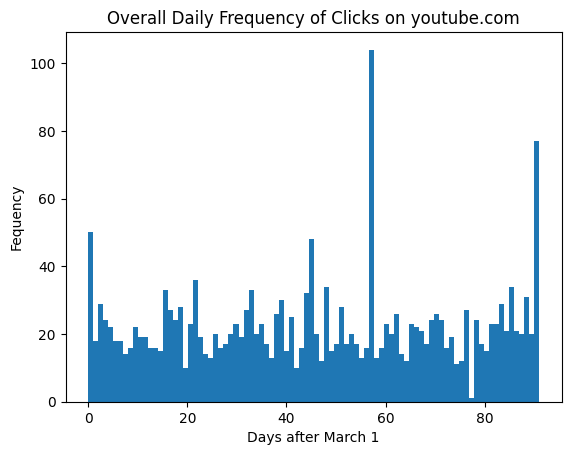

(57, 10)


7                                            rampage jackson
60                                               www.pistols
101                              welcome to silent hill .com
192                                            i pinch honda
269                                                 my space
273                                                 my space
274                                                 my space
275                                                 my space
276                                                 my space
277                                                 my space
278                                                 my space
279                                                 my space
280                                                 my space
281                                                 my space
282                                                 my space
283                                                 my space
284                     

In [4]:
# Overall Frequency Days of the Year

plt.hist(df['DAYSAFTERDBSTART'], bins=90)  # Each bin represents a day
plt.xlabel("Days after March 1")
plt.ylabel("Fequency")
plt.title("Overall Daily Frequency of Clicks on youtube.com")
plt.show()

print(df[df['DAYSAFTERDBSTART'] == 90].shape)
df[df['DAYSAFTERDBSTART'] == 90]['QUERY']

# How can queries be segmented?

#### Tokenization and embeddings of search querytext

Source: https://sbert.net/examples/applications/computing-embeddings/README.html

In [5]:
# Format input to encoder
print(df.columns)
print(df.shape)
print(df['QUERY'].values.tolist())

listOfQueries = df['QUERY'].values.tolist()

Index(['QUERY', 'month', 'day of the month', 'DAYSAFTERDBSTART', 'hour',
       'minute', 'QUERYID', 'TIMEID', 'ANONID', 'MINUTESAFTERMIDNIGHT'],
      dtype='object')
(2028, 10)
['jake peyton', 'bush drinking video', 'cant stop scratching my vagina', 'vid idiots', 'naruto websites', 'eruption-van halen', 'lip tattoos', 'rampage jackson', 'sex bomb skate program', 'beyonce skirt oop on stage', 'beyonce skirt oop on stage', 'elkins high school', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish',

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(listOfQueries , batch_size=32)


/home/chandler/anaconda3/envs/PDSP/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [7]:
# Look at embeddings

print(embeddings.shape)

(2028, 384)


#### K-Means clustering
- elbowplot
- proper K run
- assign labels
- visualization

To change the number of clusters, alter the value 2 cells down

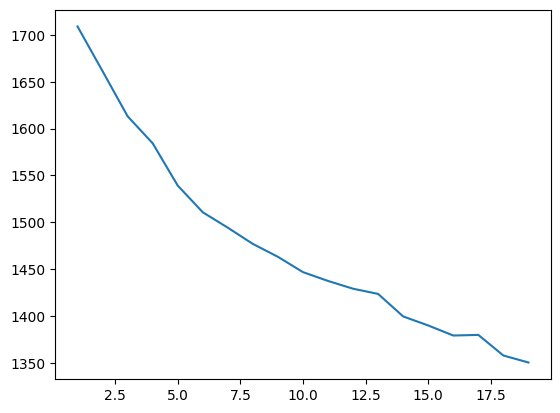

In [12]:
# Sklearn setup
from sklearn.cluster import KMeans

# Elbow plot
distortion = []
clusters = range(1,20)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(embeddings)
    distortion.append(kmeans.inertia_)

plt.plot(clusters, distortion)  # 8 appears to be a good 'elbow'


In [ ]:
# Proper K run
number_of_clusters = 3  # ALTER THIS TO CHANGE NUMBER OF CLUSTERS
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42, n_init='auto').fit(embeddings)


In [46]:
# Assign Labels -- DF column
print(kmeans.labels_)
print(kmeans.labels_.shape)
df['ClusterLabels'] = kmeans.labels_

[2 0 2 ... 0 0 2]
(2028,)


#### Check the distribution of the labels
This tells us the "n" in the following histograms

Text(0, 0.5, 'Frequency')

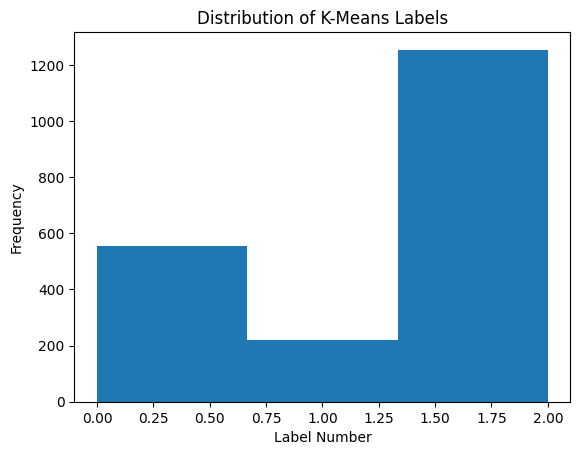

In [47]:
plt.hist(kmeans.labels_, bins=number_of_clusters)
plt.title("Distribution of K-Means Labels")
plt.xlabel("Label Number")
plt.ylabel("Frequency")

#### Plot an access time histogram for each cluster

Examine the differences in click time distributions per cluster

Cluster 0 -- Descriptive statistics and histogram
count           554
unique            3
top       april    
freq            203
Name: month, dtype: object


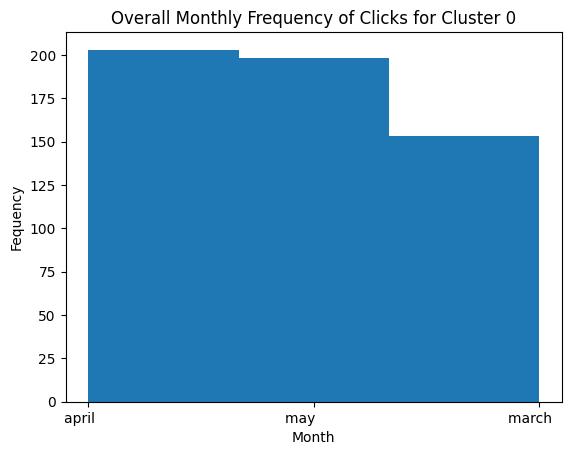

Cluster 1 -- Descriptive statistics and histogram
count           220
unique            3
top       may      
freq             91
Name: month, dtype: object


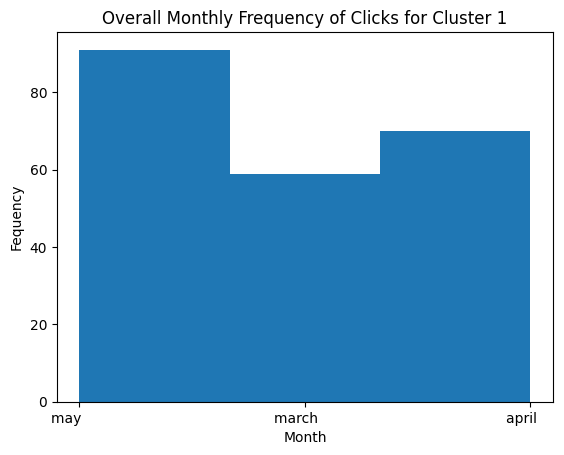

Cluster 2 -- Descriptive statistics and histogram
count          1254
unique            3
top       april    
freq            446
Name: month, dtype: object


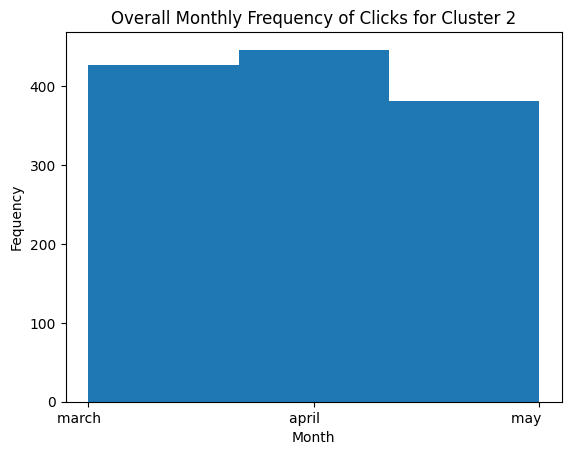

Cluster 0 -- Descriptive statistics and histogram
count    554.000000
mean      50.117329
std       25.742127
min        0.000000
25%       29.000000
50%       57.000000
75%       71.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


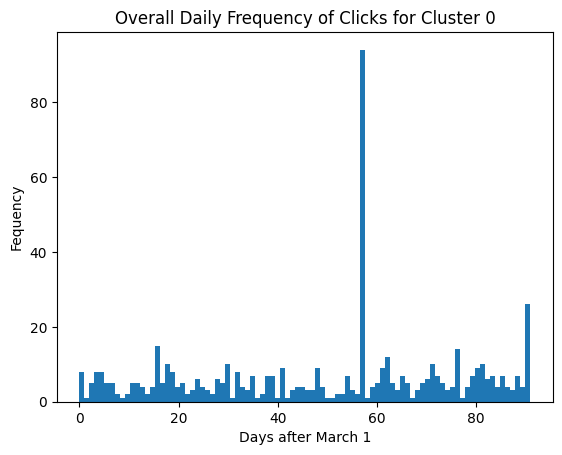

Cluster 1 -- Descriptive statistics and histogram
count    220.000000
mean      51.895455
std       27.026335
min        0.000000
25%       25.000000
50%       51.000000
75%       78.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


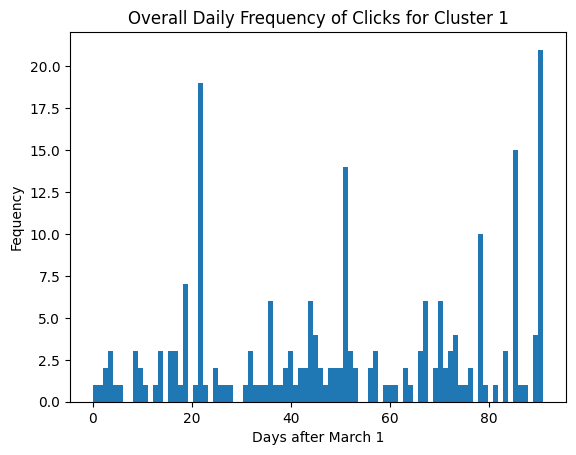

Cluster 2 -- Descriptive statistics and histogram
count    1254.000000
mean       43.999203
std        26.815187
min         0.000000
25%        21.000000
50%        44.000000
75%        66.000000
max        91.000000
Name: DAYSAFTERDBSTART, dtype: float64


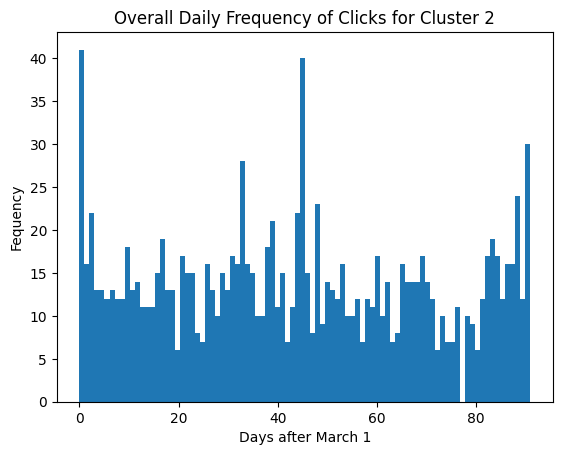

Cluster 0 -- Descriptive statistics and histogram
count     554.000000
mean      704.458484
std       394.848797
min         4.000000
25%       374.000000
50%       643.500000
75%      1038.500000
max      1437.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


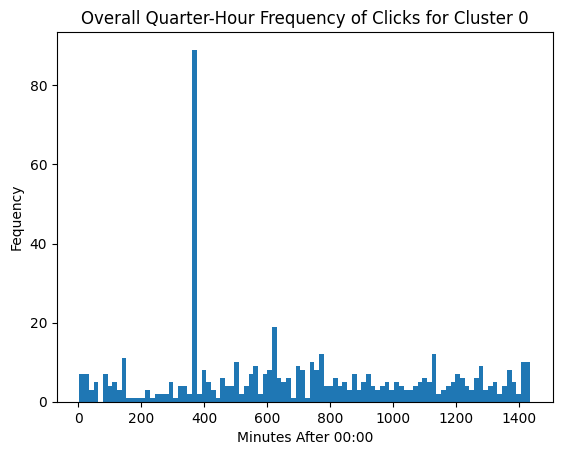

Cluster 1 -- Descriptive statistics and histogram
count     220.000000
mean      731.345455
std       376.922359
min        10.000000
25%       490.000000
50%       693.500000
75%      1024.500000
max      1423.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


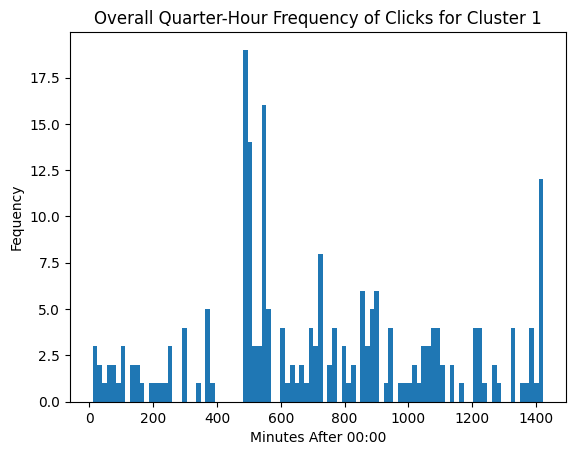

Cluster 2 -- Descriptive statistics and histogram
count    1254.000000
mean      791.244019
std       415.915127
min         1.000000
25%       496.000000
50%       809.000000
75%      1163.250000
max      1439.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


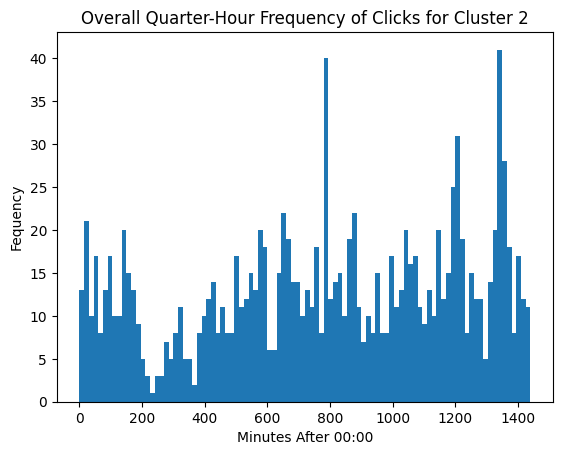

In [48]:
# At month Scale
for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['month'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['month'], bins=3)  # Each bin represents a day
    plt.xlabel("Month")
    plt.ylabel("Fequency")
    plt.title(f"Overall Monthly Frequency of Clicks for Cluster {i}")
    plt.show()
    
# At day scale
for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['DAYSAFTERDBSTART'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['DAYSAFTERDBSTART'], bins=90)  # Each bin represents a day
    plt.xlabel("Days after March 1")
    plt.ylabel("Fequency")
    plt.title(f"Overall Daily Frequency of Clicks for Cluster {i}")
    plt.show()
    
# At minute scale
for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['MINUTESAFTERMIDNIGHT'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['MINUTESAFTERMIDNIGHT'], bins=96)  # Each bin represents a day
    plt.xlabel("Minutes After 00:00")
    plt.ylabel("Fequency")
    plt.title(f"Overall Quarter-Hour Frequency of Clicks for Cluster {i}")
    plt.show()


#### PCA for visualization

Principal Component 1: 5.02% of the variance
Principal Component 2: 3.43% of the variance

Maybe this is not so good...
Alas, we have visualized more or less distinct clusters.


<Figure size 1000x800 with 0 Axes>

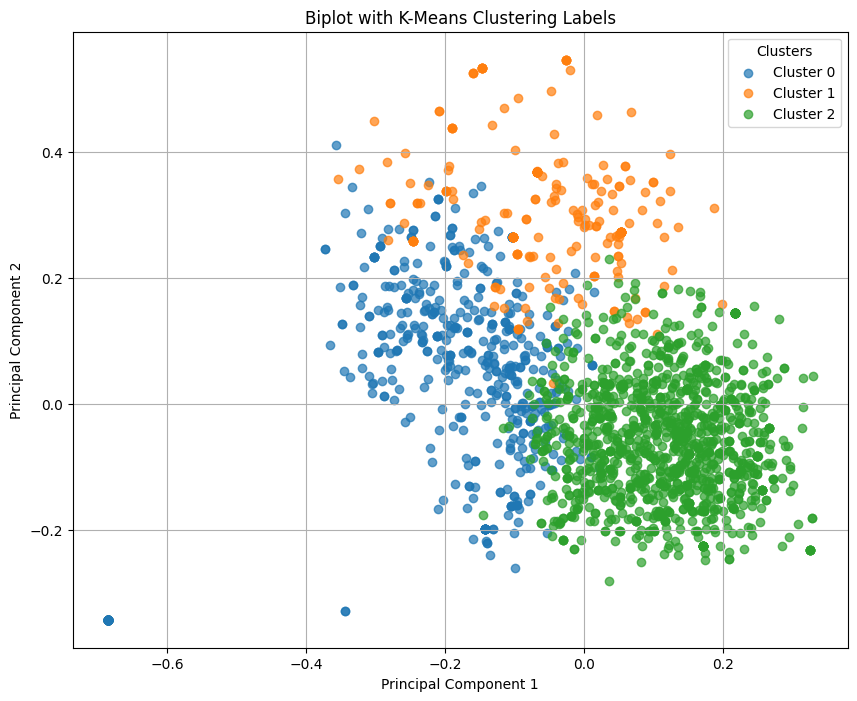

In [49]:
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 2)
reduced_embeddings = pca.fit_transform(embeddings)  # Embeddings from llm output

plt.figure(figsize=(10,8))

# Step 2: Define colors for clusters
unique_labels = np.unique(kmeans.labels_)
colors = plt.cm.tab10.colors[:len(unique_labels)]  # Choose a set of distinct colors
cmap = ListedColormap(colors)

# Step 3: Plot each cluster with a different color
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    cluster_points = reduced_embeddings[kmeans.labels_ == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(i), label=f"Cluster {label}", alpha=0.7)

explained_variance_ratio = pca.explained_variance_ratio_

# Print the results
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {variance:.2%} of the variance")

print("\nMaybe this is not so good...\nAlas, we have visualized more or less distinct clusters.")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Biplot with K-Means Clustering Labels")
plt.legend(title="Clusters")
plt.grid()
plt.show()

#### T-SNE on embeddings

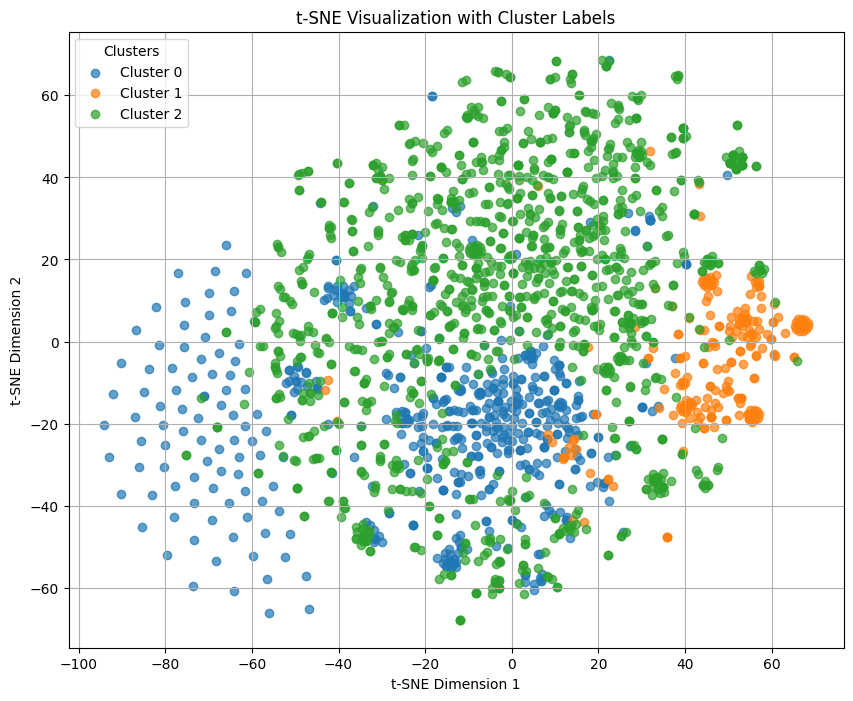

In [50]:
from sklearn.manifold import TSNE

# Sample data (replace with your own embeddings and labels)
# embeddings = np.random.rand(100, 5)  # Replace with your embedding vectors
# labels = np.random.randint(0, 4, 100)  # Replace with your k-means labels (0, 1, 2, etc.)

# Step 1: Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_embeddings = tsne.fit_transform(embeddings)

# Step 2: Define colors for each cluster
unique_labels = np.unique(kmeans.labels_)
colors = plt.cm.tab10.colors[:len(unique_labels)]

# Step 3: Plot each cluster with a different color and marker
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    cluster_points = reduced_embeddings[kmeans.labels_ == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f"Cluster {label}", alpha=0.7)

# Step 4: Add discrete legend
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Cluster Labels")
plt.legend(title="Clusters")
plt.grid()
plt.show()